In [1]:
import numpy as np
import pandas as pd
from scipy.stats import laplace
import scipy.stats
import psycopg2
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
def execQuery(query):
    try:
        connection = psycopg2.connect(user = "postgres",
                                      password = "password",
                                      host = "localhost",
                                      port = "5432",
                                      database = "bachelorBesoeg2014")
        cursor = connection.cursor()
        cursor.execute(query)
        record = cursor.fetchall()
        return record
    except (Exception, psycopg2.Error) as error :
        connection = False
        print ("Error while connecting to PostgreSQL", error)
    finally:
        if(connection):
            cursor.close()
            connection.close()
            #print("Executed query and closed connection.")

result = execQuery("""select count(*) as number_of_dates, count(DISTINCT  count_) as distinct_count from _775147;""")
result

[(1794, 475)]

In [3]:
result = execQuery("""SELECT table_name FROM information_schema.tables
       WHERE table_schema = 'public'""")
tabels = [x[0] for x in result]
tabels

['_775100',
 '_775144',
 '_775167',
 '_775120',
 '_775146',
 '_775168',
 '_775122',
 '_775147',
 '_775170',
 '_775126',
 '_775150',
 '_775127',
 '_775160',
 '_775130',
 '_775140',
 '_775164']

In [4]:
result = execQuery("""select count(*) from _775147 where count_ = 1;""")
print(result)
print(type(result[0][0]))

[(36,)]
<class 'int'>


In [5]:
requests = np.array([1,92,82,48])
ac = np.array([36,11,5,1])

In [6]:
def lap(x,b):
    return 1/(2*b) * np.exp(-(np.abs(x)/b))

In [7]:
epsilons = np.array([2,1,0.8,0.7,0.5,0.4,0.3])

In [8]:
epsilon = 2
b = 1/epsilon
print(b)
print(2*(b)**2)
laplace_mec = laplace(scale=b)
laplace_mec.var()
laplace_mec.rvs()

0.5
0.5


-0.3845055255410975

In [9]:
def laplace_mechanism(answear,epsilon):
    b = 1/epsilon
    laplace_mec = laplace(scale=b)
    Y = laplace_mec.rvs()
    return answear + Y

In [10]:
def range_count(query,epsilon):
    corret_answear = execQuery(query)[0][0]
    return laplace_mechanism(corret_answear,epsilon)

In [11]:
def mean_confidence_interval(data, confidence=0.95):
    a = 1.0 * np.array(data)
    n = len(a)
    m, se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [12]:
def confidence_interval(mean, confidence=0.95):
    se = np.mean(a), scipy.stats.sem(a)
    h = se * scipy.stats.t.ppf((1 + confidence) / 2., n-1)
    return m, m-h, m+h

In [13]:
error_dicts = {}

for e in epsilons:
    print(e)
    number_of_queries = 100
    query = """select count(*) from _775147 where count_ = 1;"""
    answears = np.zeros(number_of_queries)
    corret_answear = execQuery(query)[0][0]
    for i in range(0,number_of_queries):
        answears[i] = range_count(query,e)
    error = np.abs(corret_answear-answears)
    max_error = np.amax(error)
    min_error = np.amin(error)
    true_values = np.full(number_of_queries, corret_answear)
    mse = mean_squared_error(true_values, answears)
    error_dicts[e] = {'mse': mse, 'max': max_error, 'min': min_error }



2.0
1.0
0.8
0.7
0.5
0.4
0.3


In [14]:
#Getting all error values from dict
n = len(error_dicts)
mse_errors = np.zeros(n)
min_errors = np.zeros(n)
max_errors = np.zeros(n)

for num, item in enumerate(error_dicts.items()):
    mse_errors[num] = item[1]['mse']
    min_errors[num] = item[1]['min']
    max_errors[num] = item[1]['max']

In [15]:
error_stack = np.vstack((min_errors,mse_errors,max_errors)).flatten()
min_labels = np.full(min_errors.size, 'min errors')
mse_labels = np.full(mse_errors.size, 'mse errors')
max_labels = np.full(max_errors.size, 'max errors')
labels_stack = np.vstack((min_labels,mse_labels,max_labels)).flatten()
epsilons_stack = np.vstack((epsilons,epsilons,epsilons)).flatten()


In [16]:
seaborn_df = pd.DataFrame({'epsilons':epsilons_stack, 'errors':error_stack,'labels':labels_stack})
seaborn_df.to_csv('seaborn_plotting_data.csv',index=False)

In [17]:
all_data = pd.DataFrame({'epsilons':epsilons, 'min_errors':min_errors,'max_errors':min_errors,'mse_errors':mse_errors})
all_data.to_csv('plotting_data.csv',index=False)

In [18]:
sns.set_theme()

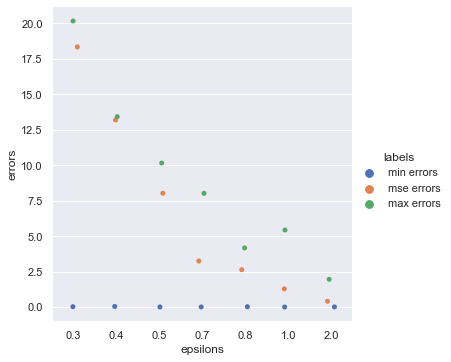

In [19]:
sns.catplot(x="epsilons", y="errors", hue="labels", data=seaborn_df)

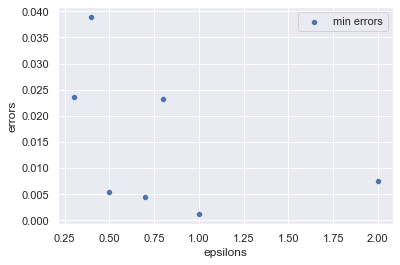

In [20]:
sns.scatterplot(data=seaborn_df.loc[seaborn_df['labels'] == 'min errors'], x ='epsilons', y ='errors')
plt.legend(labels=['min errors'])

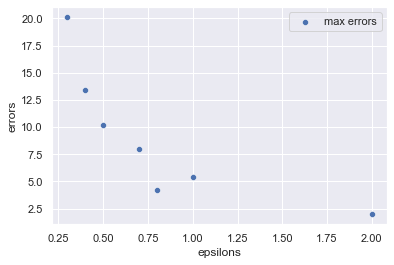

In [21]:
sns.scatterplot(data=seaborn_df.loc[seaborn_df['labels'] == 'max errors'], x ='epsilons', y ='errors')
plt.legend(labels=['max errors'])

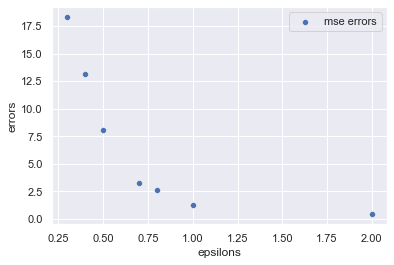

In [22]:
sns.scatterplot(data=seaborn_df.loc[seaborn_df['labels'] == 'mse errors'], x ='epsilons', y ='errors')
plt.legend(labels=['mse errors'])

In [23]:
def get_means(data):
    means = np.zeros(data.size)
    for i in range(0,data.size):
        means[i] = np.mean(data[0:i+1]) 
    print(np.mean(data))
    return means

In [42]:
epsilon = 2
number_of_queries = 100
query = """select count(*) from _775147 where count_ = 1;"""
answears = np.zeros(number_of_queries)
corret_answear = execQuery(query)[0][0]
for i in range(0,number_of_queries):
    answears[i] = range_count(query,e)
means = get_means(answears)

36.55799190090924


In [43]:
upper = np.zeros(number_of_queries)
lower = np.zeros(number_of_queries)

for i in range(0,100):
    mean, low, up = mean_confidence_interval(answears[0:i+1])
    upper[i] = up
    lower[i] = low
    
upper = upper[-99:] 
lower = lower[-99:]

In [44]:
print(upper)
print(lower)

[59.05400732 42.34512425 39.4361688  39.21884352 38.43703582 37.80614108
 37.258958   36.7956322  36.80196332 36.57181756 36.48791381 36.22342997
 36.319148   37.54070951 37.5633084  37.48553364 37.89071432 37.81005102
 39.5547782  39.37794066 39.31726325 38.96707274 38.68223793 38.48486375
 38.58419811 38.36660415 38.27581285 38.25798935 38.14139344 38.20260546
 38.03987061 38.07831711 38.03443314 37.88120332 37.8565681  37.75409469
 37.694179   38.50645899 38.4696347  38.38971951 38.17890178 38.07675116
 38.02419498 38.0399367  38.00435805 38.01239123 37.9755311  38.01287593
 37.98203766 37.9578844  38.00900725 37.97166032 38.00014707 38.13207841
 38.11429986 38.11936237 38.06078283 38.00704857 37.96274889 37.98673684
 38.03000664 37.97585512 38.04623475 37.98313654 37.96065762 37.95529732
 37.99551404 37.89325267 37.77943903 37.76340193 37.78497095 37.69976247
 37.71542471 37.59693168 38.24238301 38.13085932 38.09499556 38.07130928
 38.03073525 37.99340655 37.94965316 37.93118277 37

In [33]:
xs = np.arange(99)+2

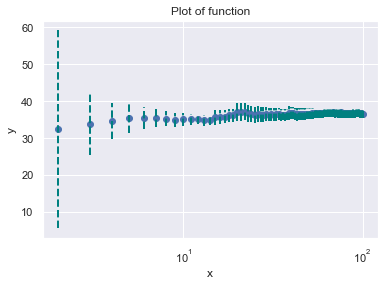

In [45]:
fig = plt.figure(1)
#p1, = plt.plot(xs, ys, 'ro', label='Data points')
#p2, = plt.plot(t, p, 'b-.', label='Approx')
p3 = plt.scatter(xs, means[-(number_of_queries-1):])
plt.vlines(x=xs, ymin=lower, ymax=upper, colors='teal', ls='--', lw=2)

plt.xlabel('x')
plt.ylabel('y')
plt.xscale("log")
plt.title('Plot of function')
plt.grid(True)
plt.show()



In [28]:
"""
import numpy as np
import matplotlib.pyplot as plt

xs = np.linspace(1, 21, 200)

plt.figure(figsize=(10, 7))

# only one line may be specified; full height
plt.axvline(x=36, color='b', label='axvline - full height')

# only one line may be specified; ymin & ymax spedified as a percentage of y-range
plt.axvline(x=36.25, ymin=0.05, ymax=0.95, color='b', label='axvline - % of full height')

# multiple lines all full height
plt.vlines(x=[37, 37.25, 37.5], ymin=0, ymax=len(xs), colors='purple', ls='--', lw=2, label='vline_multiple - full height')

# multiple lines with varying ymin and ymax
plt.vlines(x=[38, 38.25, 38.5], ymin=[0, 25, 75], ymax=[200, 175, 150], colors='teal', ls='--', lw=2, label='vline_multiple - partial height')

# single vline with full ymin and ymax
plt.vlines(x=39, ymin=0, ymax=len(xs), colors='green', ls=':', lw=2, label='vline_single - full height')

# single vline with specific ymin and ymax
plt.vlines(x=39.25, ymin=25, ymax=150, colors='green', ls=':', lw=2, label='vline_single - partial height')

# place legend outside
plt.legend(bbox_to_anchor=(1.0, 1), loc='upper left')

plt.show()
"""

"\nimport numpy as np\nimport matplotlib.pyplot as plt\n\nxs = np.linspace(1, 21, 200)\n\nplt.figure(figsize=(10, 7))\n\n# only one line may be specified; full height\nplt.axvline(x=36, color='b', label='axvline - full height')\n\n# only one line may be specified; ymin & ymax spedified as a percentage of y-range\nplt.axvline(x=36.25, ymin=0.05, ymax=0.95, color='b', label='axvline - % of full height')\n\n# multiple lines all full height\nplt.vlines(x=[37, 37.25, 37.5], ymin=0, ymax=len(xs), colors='purple', ls='--', lw=2, label='vline_multiple - full height')\n\n# multiple lines with varying ymin and ymax\nplt.vlines(x=[38, 38.25, 38.5], ymin=[0, 25, 75], ymax=[200, 175, 150], colors='teal', ls='--', lw=2, label='vline_multiple - partial height')\n\n# single vline with full ymin and ymax\nplt.vlines(x=39, ymin=0, ymax=len(xs), colors='green', ls=':', lw=2, label='vline_single - full height')\n\n# single vline with specific ymin and ymax\nplt.vlines(x=39.25, ymin=25, ymax=150, colors='g